<a href="https://colab.research.google.com/github/rouzbehshi/Model/blob/main/Input%20Data/Demand_Scenario_Generation_rev3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import pytz
from datetime import datetime
import io
import matplotlib.pyplot as plt

Importing hourly electricity demand of SDGE, from 2019 to end of 2030, HIGH-LOW scenario.

In [ ]:
url1 = 'https://raw.githubusercontent.com/rouzbehshi/Model/main/Input%20Data/CED%202019%20Hourly%20Results%20-%20SDGE%20-%20HIGH-LOW.csv'
SDGE_High_Low = pd.read_csv(url1)
SDGE_High_Low=pd.DataFrame(SDGE_High_Low)
cols=['YEAR','MONTH','DAY','HOUR','MANAGED_NET_LOAD']
SDGE_High_Low=SDGE_High_Low.iloc[:][cols]
SDGE_High_Low.rename(columns={"MANAGED_NET_LOAD": "NET_LOAD"},inplace = True)
print(SDGE_High_Low)

        YEAR  MONTH  DAY  HOUR  NET_LOAD
0       2019      1    1     1  2084.471
1       2019      1    1     2  1991.779
2       2019      1    1     3  1930.597
3       2019      1    1     4  1900.568
4       2019      1    1     5  1915.168
...      ...    ...  ...   ...       ...
105115  2030     12   31    20  3279.552
105116  2030     12   31    21  3221.024
105117  2030     12   31    22  3088.264
105118  2030     12   31    23  2863.114
105119  2030     12   31    24  2728.959

[105120 rows x 5 columns]


Importing hourly electricity demand of SDGE, from 2019 to end of 2030, LOW_High scenario.

In [ ]:
url2 = 'https://raw.githubusercontent.com/rouzbehshi/Model/main/Input%20Data/CED%202019%20Hourly%20Results%20-%20SDGE%20-%20LOW-HIGH.csv'
SDGE_Low_High = pd.read_csv(url2)
SDGE_Low_High=pd.DataFrame(SDGE_Low_High)
cols=['YEAR','MONTH','DAY','HOUR','MANAGED_NET_LOAD']
SDGE_Low_High=SDGE_Low_High.iloc[:][cols]
SDGE_Low_High.rename(columns={"MANAGED_NET_LOAD": "NET_LOAD"},inplace = True)
print(SDGE_Low_High)

        YEAR  MONTH  DAY  HOUR  NET_LOAD
0       2019      1    1     1  2059.254
1       2019      1    1     2  1963.970
2       2019      1    1     3  1902.445
3       2019      1    1     4  1873.008
4       2019      1    1     5  1889.043
...      ...    ...  ...   ...       ...
105115  2030     12   31    20  2901.300
105116  2030     12   31    21  2837.925
105117  2030     12   31    22  2718.853
105118  2030     12   31    23  2523.631
105119  2030     12   31    24  2402.228

[105120 rows x 5 columns]


Importing hourly electricity demand of SDGE, from 2019 to end of 2030, Mid_Mid scenario.

In [ ]:
url3 = 'https://raw.githubusercontent.com/rouzbehshi/Model/main/Input%20Data/CED%202019%20Hourly%20Results%20-%20SDGE%20-%20MID-MID.csv'
SDGE_Mid_Mid = pd.read_csv(url3)
SDGE_Mid_Mid=pd.DataFrame(SDGE_Mid_Mid)
cols=['YEAR','MONTH','DAY','HOUR','MANAGED_NET_LOAD']
SDGE_Mid_Mid=SDGE_Mid_Mid.iloc[:][cols]
SDGE_Mid_Mid.rename(columns={"MANAGED_NET_LOAD": "NET_LOAD"},inplace = True)
print(SDGE_Mid_Mid)

        YEAR  MONTH  DAY  HOUR  NET_LOAD
0       2019      1    1     1  2067.440
1       2019      1    1     2  1972.239
2       2019      1    1     3  1910.903
3       2019      1    1     4  1881.541
4       2019      1    1     5  1897.109
...      ...    ...  ...   ...       ...
105115  2030     12   31    20  3190.486
105116  2030     12   31    21  3133.117
105117  2030     12   31    22  3005.066
105118  2030     12   31    23  2770.203
105119  2030     12   31    24  2656.698

[105120 rows x 5 columns]


Creating a dataset which contains all three scenarios.

Extracting the Month

In [ ]:
month=9 # September

In [ ]:
N=5 # Number of Scenarios

In [ ]:
def generate_scenarios(month, N, SDGE_High_Low):
    # Filter data by month
    SDGE_High_Low_month = SDGE_High_Low[SDGE_High_Low['MONTH'] == month]
    
    # Calculate mean and std for each day and hour
    df_mean = SDGE_High_Low_month.groupby(['DAY', 'HOUR'])['NET_LOAD'].mean()
    df_std = SDGE_High_Low_month.groupby(['DAY', 'HOUR'])['NET_LOAD'].std()

    # Normal distribution probability of each segment
    segment1 = [norm.pdf(df_mean[i,j], loc=df_mean[i,j], scale=df_std[i,j]) for i in [*range(1,31)] for j in [*range(1,25)]]
    segment2 = [norm.pdf(df_mean[i,j]+df_std[i,j], loc=df_mean[i,j], scale=df_std[i,j]) for i in [*range(1,31)] for j in [*range(1,25)]]
    segment3 = [norm.pdf(df_mean[i,j]-df_std[i,j], loc=df_mean[i,j], scale=df_std[i,j]) for i in [*range(1,31)] for j in [*range(1,25)]]

    # Normalize the probability values
    prob_norm1 = [segment1[i]*1000/((segment1[i]+segment2[i]+segment3[i])*1000) for i in [*range(30*24)]]
    prob_norm2 = [segment2[i]*1000/((segment1[i]+segment2[i]+segment3[i])*1000) for i in [*range(30*24)]]
    prob_norm3 = [segment3[i]*1000/((segment1[i]+segment2[i]+segment3[i])*1000) for i in [*range(30*24)]]

    # Accumulated normalized probability
    prob_acc1 = [prob_norm1[i] for i in [*range(len(prob_norm1))]]
    prob_acc2 = [prob_norm1[i]+prob_norm2[i] for i in [*range(len(prob_norm1))]]
    prob_acc3 = [prob_norm1[i]+prob_norm2[i]+prob_norm3[i] for i in [*range(len(prob_norm1))]]

    # Convert dataframes to lists
    m=pd.DataFrame(df_mean)
    m = m.reset_index(drop=True)
    m.index = pd.RangeIndex(0, 720)
    m_list = m.values.tolist()

    std=pd.DataFrame(df_std)
    std = std.reset_index(drop=True)
    std.index = pd.RangeIndex(0, 720)
    std_list = std.values.tolist()
    scenario_prob = []
    day_values = []
    for i in range(N):
      scenario = []
      day_prob = 1
      day_prob = np.float128(day_prob)
      for j in range(720):
        rand = np.random.uniform(0,1)
        # rand=abs(np.random.randn())
        if rand <= prob_acc1[j]:
            scenario.append(m_list[j][0]-std_list[j][0])
            day_prob *= prob_norm1[j]
            
        elif rand <= prob_acc2[j]:
            scenario.append(m_list[j][0])
            day_prob *= prob_norm2[j]
            
        else:
            scenario.append(m_list[j][0]+std_list[j][0])
            day_prob *= prob_norm3[j]
            
      scenario_prob.append(day_prob)
      day_values.append(scenario)
       
    # # Normalized scenario probability
    scenario_prob_norm = [scenario_prob[i]/sum(scenario_prob) for i in range(N)]

    return (day_values,scenario_prob_norm)

In [ ]:
def extract_data_by_day(scenarios, start_day, end_day):
    start_hour = start_day * 24
    end_hour = end_day * 24
    extracted_data = []
    for scenario in scenarios:
        extracted_data.append(scenario[start_hour:end_hour])
    return extracted_data

In [ ]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [ ]:
def plot_extracted_data(extracted_data, scenario_prob_norm,name):
    num_scenarios = len(extracted_data)
    plt.figure(figsize=(15, 7))
    for i in range(num_scenarios):
        plt.plot(extracted_data[i], label='Scenario ' + str(i+1) + ' (Prob: {:.0%})'.format(scenario_prob_norm[i]))
    plt.xlabel("Hour")
    plt.ylabel("Demand")
    plt.title(""+str(name))
    plt.legend()
    plt.show()

Converting the output to be in the form of Model input.

In [ ]:
def format(extracted_data):
  c=pd.DataFrame(extracted_data)
  demand = {}
  for x in extracted_data:
    hour=len(x)
  for i in range(hour):
    demand[i] = {}
    for j in range(len(extracted_data)):
      demand[i][j+1] = c.iloc[j, i]
  return(demand)


**SDGE_High_Low MCS:**

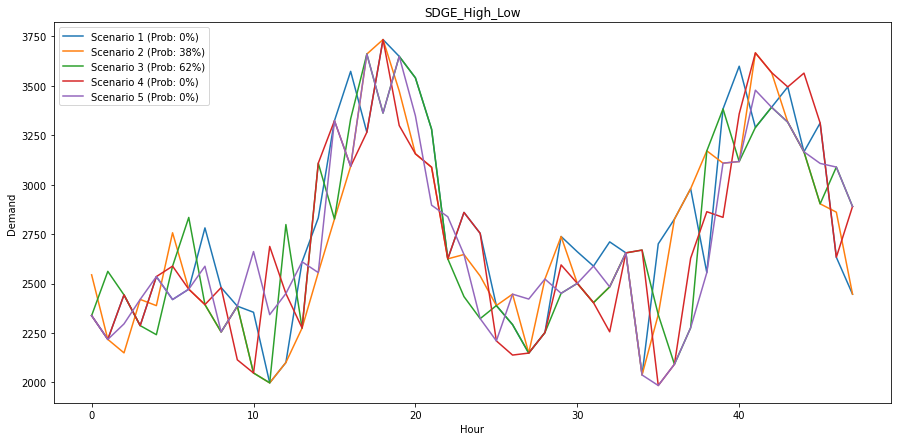

In [ ]:
start=7 #The first day (Included)
end=9 #The last day (Excluded)
month=9
N=5
name=get_df_name(SDGE_High_Low)
day_values1,scenario_prob_norm1=generate_scenarios(month,N,SDGE_High_Low)
extracted_data1=extract_data_by_day(day_values1,start,end)
demand1=format(extracted_data1)
plot_extracted_data(extracted_data1,scenario_prob_norm1,name)

**SDGE_Low_High MCS:**

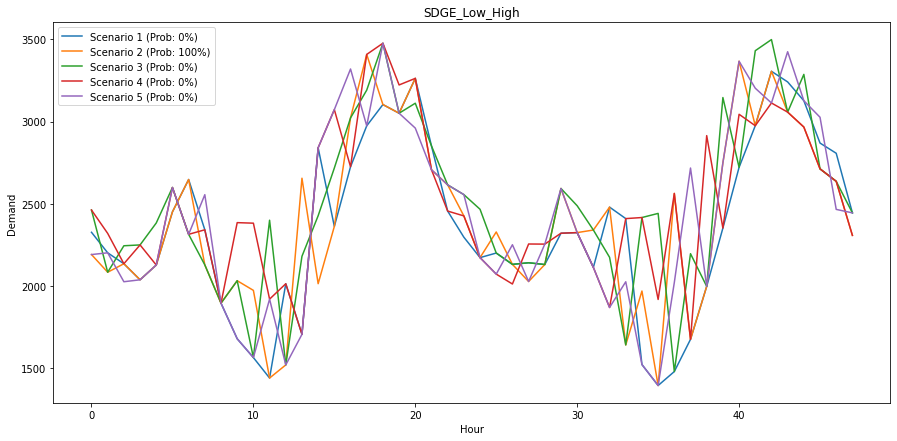

In [ ]:
start=7 #The first day (Included)
end=9 #The last day (Excluded)
month=9
N=5
name=get_df_name(SDGE_Low_High)
day_values2, scenario_prob_norm2 = generate_scenarios(month,N,SDGE_Low_High)
extracted_data2=extract_data_by_day(day_values2,start,end)
demand2=format(extracted_data2)
plot_extracted_data(extracted_data2,scenario_prob_norm2,name)

**SDGE_Mid_Mid MCS:**

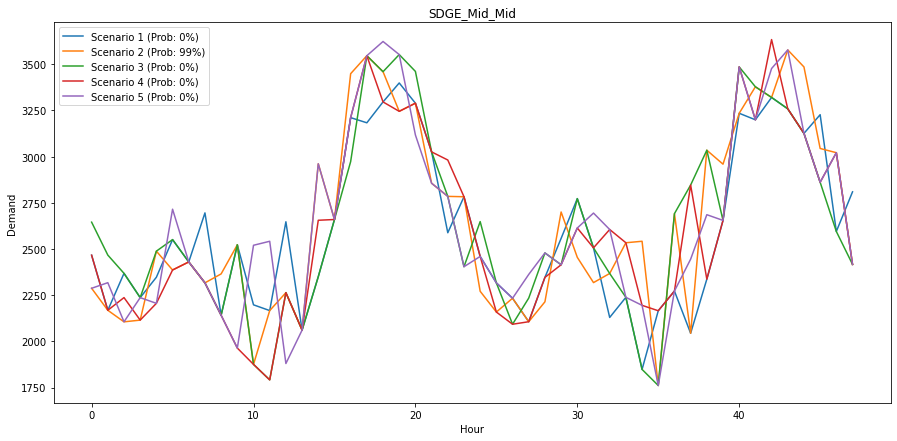

In [ ]:
start=7 #The first day (Included)
end=9 #The last day (Excluded)
month=9
N=5
name=get_df_name(SDGE_Mid_Mid)
day_values3, scenario_prob_norm3 = generate_scenarios(month,N,SDGE_Mid_Mid)
extracted_data3 = extract_data_by_day(day_values3,start,end)
demand3=format(extracted_data3)
plot_extracted_data(extracted_data3,scenario_prob_norm3,name)